In [19]:
import pandas as pd
import numpy as np
from scipy.stats import beta, weibull_min
from datetime import timedelta

C:\Users\carlv\AppData\Local\Temp\ipykernel_8472\2409071396.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [20]:
df_path='../data/data_wind_solar_2024_25.csv'

df = pd.read_csv(df_path, sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
df["Datum"] = df['Datum'].dt.tz_localize(None)
df.set_index('Datum', inplace=True)
df.columns = ['Wind', 'Solar']
day = None
if day is None:
    day = df.index[0] + timedelta(days=int(365/2))  # middle of the year
day = pd.to_datetime(day)

# normalize wind and solar to [0,1]
df = df.copy()
df['Wind'] = df['Wind'].clip(lower=0) / (df['Wind'].max() + 1e-9)
df['Solar'] = df['Solar'].clip(lower=0) / (df['Solar'].max() + 1e-9)


In [21]:
# Select ±1 month window
start = day - pd.DateOffset(months=1)
end = day + pd.DateOffset(months=1)
df_window = df.loc[start:end]

In [22]:
# resample to hourly data
df_s = df_window['Solar']
df_s = df_s.groupby([df_s.index.hour]).apply(list)

In [23]:
def get_alpha_beta_mean(data, thresh=0.02):
    if np.mean(data) < thresh:
        return 0.0
    a, b, loc, scale = beta.fit(data)
    mean = beta.mean(a, b, loc=loc, scale=scale)
    return mean

In [24]:
# df_s.apply(lambda x: get_alpha_beta_mean(x))

In [25]:
df_w = df_window['Wind']
df_w = df_w.groupby([df_w.index.hour]).mean()

In [26]:
df_bat = pd.read_csv('../data/battery_soc_profile.csv', sep=';')


In [27]:
from time_varying_dc_gain import get_wind_solar_dc_gains

In [28]:
path='../data/data_wind_solar_2024_25.csv'
df = pd.read_csv(path, sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
df.set_index('Datum', inplace=True)
df.columns = ['Wind', 'Solar']
# normalize by max values
max_vals = df.max()
df_mean = df / max_vals

In [29]:
df_bat = pd.read_csv('../data/battery_soc_profile.csv', sep=';', index_col=0)
df_bat.loc[24, 'Battery_SOC (MWh)']

3.5

In [30]:
idx=101
print(df_mean.index[idx].weekday(), df_mean.index[idx].hour, df_mean.index[idx].minute)

3 23 15


## check forecast vs. realization for wind

In [ ]:
path='../data/data_wind_solar_2024_25_forecast.csv'
df_forecast = pd.read_csv(path, sep=';')
df_forecast.drop('endTime', inplace=True, axis=1)
df_forecast.rename(columns={'startTime': 'Datum'}, inplace=True)
df_forecast["Datum"] = pd.to_datetime(df_forecast["Datum"], format='mixed')
df_forecast.set_index('Datum', inplace=True)
df_forecast.columns = ['Wind_forecast', 'Solar_forecast']

In [37]:
import matplotlib.pyplot as plt

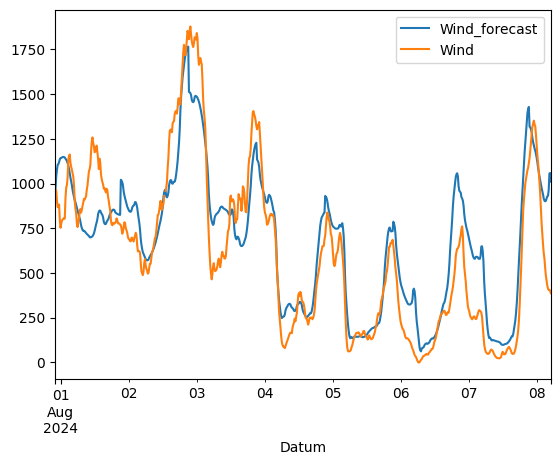

In [39]:
# compare wind forecast vs. realization for first week, i.e. ca. 700 indexes
df_forecast['Wind_forecast'].iloc[0:700].plot()
df['Wind'].iloc[0:700].plot()
plt.legend()
plt.show()

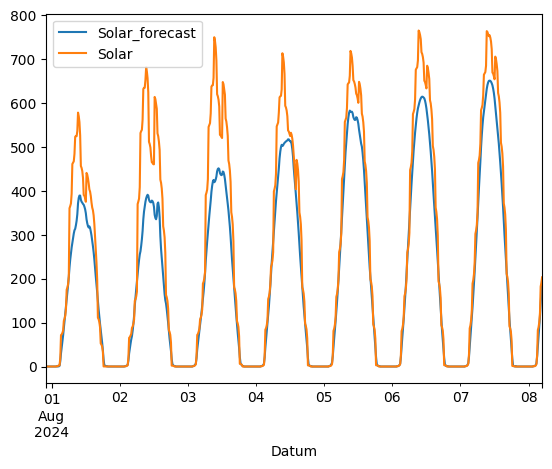

In [40]:
# compare solar forecast vs. realization for first week, i.e. ca. 700 indexes
df_forecast['Solar_forecast'].iloc[0:700].plot()
df['Solar'].iloc[0:700].plot()
plt.legend()
plt.show()  

In [33]:
df_forecast

,Wind_forecast,Solar_forecast
Datum,,
2024-07-31 22:00:00+00:00,856.6,0.0
2024-07-31 22:15:00+00:00,975.2,0.0
2024-07-31 22:30:00+00:00,1041.7,0.0
2024-07-31 22:45:00+00:00,1078.4,0.0
2024-07-31 23:00:00+00:00,1105.0,0.0
...,...,...
2025-07-31 20:45:00+00:00,1642.0,0.0
2025-07-31 21:00:00+00:00,1414.7,0.0
2025-07-31 21:15:00+00:00,1424.6,0.0


In [31]:
df

,Wind,Solar
Datum,,
2024-07-31 22:00:00+00:00,970.819,0.0
2024-07-31 22:15:00+00:00,968.006,0.0
2024-07-31 22:30:00+00:00,959.571,0.0
2024-07-31 22:45:00+00:00,902.011,0.0
2024-07-31 23:00:00+00:00,867.776,0.0
...,...,...
2025-09-13 20:45:00+00:00,NaN,0.0
2025-09-13 21:00:00+00:00,NaN,0.0
2025-09-13 21:15:00+00:00,NaN,0.0


## bid opt section

In [18]:
import numpy as np
from scipy.optimize import minimize_scalar

# Example data
p = np.array([0.1, 0.2, 0.3, 0.4])   # probabilities for each k
b_k = np.array([0.34, 0.7, 1.0, 1.5]) # threshold values for comparison
pi = 100                             # historic average price

# Expected reward function
def expected_reward(b, p, b_k, pi):
    # reward depends on whether b_k >= b
    r_k = np.where(b_k >= b, b * pi, -3 * b * pi)
    return np.sum(p * r_k)

# Objective for optimization (maximize reward)
def objective(b):
    return -expected_reward(b, p, b_k, pi)

# Optimize within a reasonable range
res = minimize_scalar(objective, bounds=(0, max(b_k) * 1.5), method='bounded')

b_opt = res.x
reward_opt = -res.fun

print(f"Optimal bid b*: {b_opt:.4f}")
print(f"Maximum expected reward: {reward_opt:.4f}")


Optimal bid b*: 0.7000
Maximum expected reward: 41.9999


In [9]:
b = 0.7
expected_reward(b, p, b_k, pi)

42.0